## Pré-Processamento
---

#### Imports e Configurações

In [1]:
import pandas as pd
from   minio import Minio
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from   sklearn.preprocessing import MinMaxScaler
from   sklearn.model_selection import train_test_split

from   sklearn.tree import DecisionTreeClassifier
from   sklearn.linear_model import LogisticRegression
from   sklearn.tree import DecisionTreeClassifier
from   sklearn.ensemble import RandomForestClassifier

from   sklearn.metrics import roc_auc_score
from   sklearn.metrics import accuracy_score
from   sklearn.metrics import classification_report
from   sklearn.metrics import confusion_matrix
from   sklearn.metrics import ConfusionMatrixDisplay

#from lazypredict.Supervised import LazyClassifier

import pickle
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Cliente do datalake
client = Minio(
        "localhost:9000",
        access_key="minioadmin",
        secret_key="minioadmin",
        secure=False
    )

#### Funções auxiliares

In [3]:
# Baseline Model: 
# sempre retorna a classe mais frequente da variável resposta (0)

def base_rate_model(X) :
    y = np.zeros(X.shape[0])
    return y

# Mostrar acurácia do modelo
def accuracy_result(y_test,y_predict):
    acc = accuracy_score(y_test, y_predict)
    print ("Accuracy = %2.2f" % acc)

def show_model_confusion_matrix(y_test, y_predict, title, labels=[0, 1]):
    cm = confusion_matrix(y_test, y_predict)
    plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    plot.plot()
    plt.grid(False)
    plt.title(title)
    plt.show();


# Mostrar curva AUC-ROC do modelo
def roc_classification_report_results(model,y_test,y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    print ("\n{} AUC = {}\n".format(model, roc_))
    print(classfication_report)
    return roc_;

#### Carregando o dataset do datalake

In [4]:
client.fget_object(
            "processing",
            "employees_dataset.parquet",
            "temp_.parquet",
)
df = pd.read_parquet("temp_.parquet")

In [5]:
df.head(5)

,department,salary,left,mean_work_last_3_months,number_projects,satisfaction_level,last_evaluation,time_in_company,work_accident
0,sales,low,1.0,266.000000,2.0,38.0,53.0,3.0,0.0
1,sales,medium,1.0,252.000000,5.0,80.0,86.0,6.0,0.0
2,sales,medium,1.0,289.666667,7.0,11.0,88.0,4.0,0.0
3,sales,low,1.0,275.666667,5.0,72.0,87.0,5.0,0.0
4,sales,low,1.0,292.333333,2.0,37.0,52.0,3.0,0.0


#### Pré-processamento dos dados

##### Reorganizar colunas e exluir valores missing

In [6]:
df.dropna(inplace=True)
df = df[['department', 'salary', 'mean_work_last_3_months',
       'number_projects', 'satisfaction_level', 'last_evaluation',
       'time_in_company', 'work_accident','left']]

##### Alterar tipos de dados

In [7]:
# Numéricos
df["number_projects"] = df["number_projects"].astype(int)
df["mean_work_last_3_months"] = df["mean_work_last_3_months"].astype(int)
df["time_in_company"] = df["time_in_company"].astype(int)
df["work_accident"] = df["work_accident"].astype(int)
df["left"] = df["left"].astype(int)

# Categóricos
df["department"] = df["department"].astype('category').cat.codes
df["salary"] = df["salary"].astype('category').cat.codes

##### Renomear atributos

In [8]:
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_projects': 'projectCount',
                        'mean_work_last_3_months': 'averageMonthlyHours',
                        'time_in_company': 'yearsAtCompany',
                        'work_accident': 'workAccident',
                        'left' : 'turnover'
                        })

##### Separando variáveis preditoras x resposta

In [9]:
target_name = 'turnover'
X = df.drop('turnover', axis=1)
y = df[target_name]

In [10]:
X.shape, y.shape

((14999, 8), (14999,))

##### Rescalonamento das variáveis preditoras

In [11]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#### Features Selection

Para entender qual são as variáveis mais importantes para o modelo, vamos treinar o algoritmo com todas as variáveis preditoras (X) e extrair a importância relativa de cada uma delas. Depois, retreinaremos o modelo, mas dessa vez utilizando apenas as variáveis preditoras + importantes.

In [12]:
# Configs
test_size = 0.2
random_state = 42
stratify = y

In [13]:
# Bases de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify = stratify)

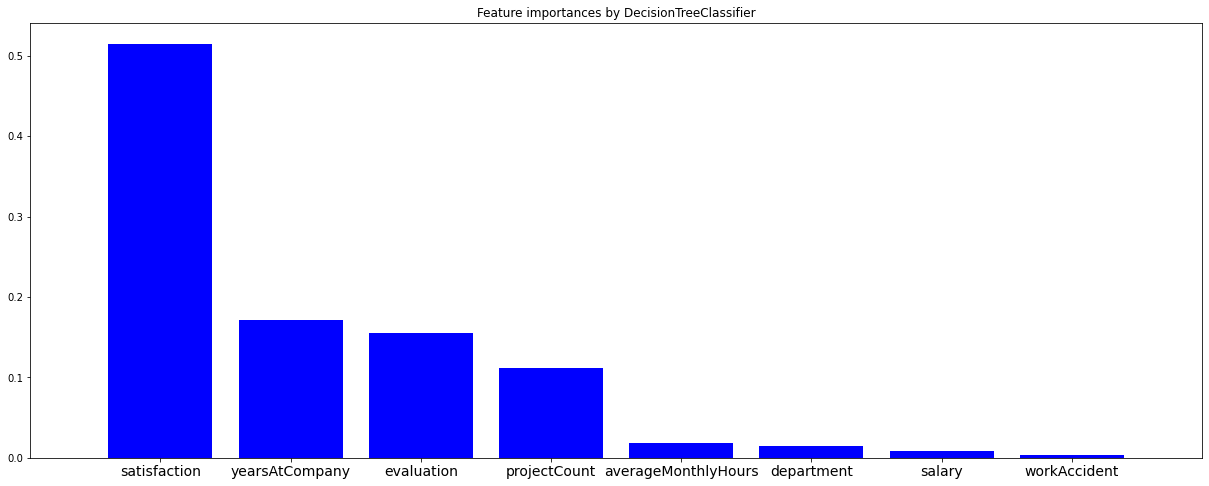

In [14]:
# Primeiro treino
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train,y_train)

# Importância das variáveis para o algoritmo treinado
importances = dtree.feature_importances_
feat_names = df.drop(['turnover'],axis=1).columns

# Plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(21,8))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='b',  align="center")
plt.xticks(range(len(indices)), feat_names[indices],fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

##### Filtrando apenas as variáveis + importantes

In [15]:
X = df[["satisfaction","yearsAtCompany", "evaluation","projectCount", "averageMonthlyHours"]]
#X = scaler.fit_transform(X)

---
## Construção dos modelos de ML

##### Configs

In [16]:
# Configs
test_size = 0.2
random_state = 42
stratify = y

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify = stratify)

print(f'----------')
print(f'Bases de treino: {X_train.shape, y_train.shape}')
print(f'Bases de teste: {X_test.shape, y_test.shape}')

----------
Bases de treino: ((11999, 5), (11999,))
Bases de teste: ((3000, 5), (3000,))


##### Baseline model

Accuracy = 0.76

Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      2286
           1       0.00      0.00      0.00       714

    accuracy                           0.76      3000
   macro avg       0.38      0.50      0.43      3000
weighted avg       0.58      0.76      0.66      3000



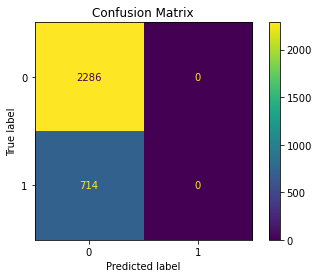

In [18]:
y_predict = base_rate_model(X_test)
accuracy_result(y_test, y_predict)
auc_baseline = roc_classification_report_results("Base Model", y_test, y_predict)
show_model_confusion_matrix(y_test, y_predict, "Confusion Matrix")

##### Regressão Logística

In [19]:
logis = LogisticRegression()
logis.fit(X_train, y_train)
y_predict = logis.predict(X_test)

Accuracy = 0.77

Regressão Logística AUC = 0.5950837027724476

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      2286
           1       0.52      0.27      0.35       714

    accuracy                           0.77      3000
   macro avg       0.66      0.60      0.61      3000
weighted avg       0.73      0.77      0.74      3000



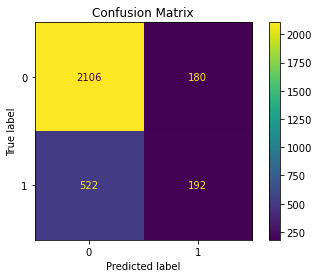

In [20]:
accuracy_result(y_test, y_predict)
auc_logis = roc_classification_report_results("Regressão Logística", y_test, y_predict)
show_model_confusion_matrix(y_test, y_predict, "Confusion Matrix")

##### Árvore de Decisão

In [21]:
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train,y_train)
y_predict = dtree.predict(X_test)

Accuracy = 0.97

Tree Decision AUC = 0.956283038149643

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2286
           1       0.92      0.94      0.93       714

    accuracy                           0.97      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.97      0.97      0.97      3000



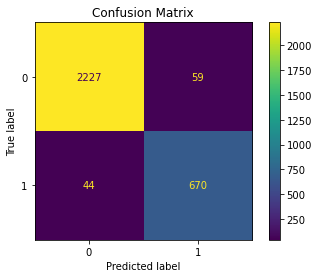

In [22]:
accuracy_result(y_test, y_predict)
auc_dtree = roc_classification_report_results("Tree Decision", y_test, y_predict)
show_model_confusion_matrix(y_test, y_predict, "Confusion Matrix")

##### Random Forest

In [23]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
y_predict = rf.predict(X_test)

In [24]:
df = df.rename(columns={'satisfaction_level': 'satisfaction', 
                        'last_evaluation': 'evaluation',
                        'number_projects': 'projectCount',
                        'mean_work_last_3_months': 'averageMonthlyHours',
                        'time_in_company': 'yearsAtCompany',
                        'work_accident': 'workAccident',
                        'left' : 'turnover'
                        })

Accuracy = 0.98

Random Forest AUC = 0.9610048743907011

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2286
           1       0.98      0.93      0.95       714

    accuracy                           0.98      3000
   macro avg       0.98      0.96      0.97      3000
weighted avg       0.98      0.98      0.98      3000



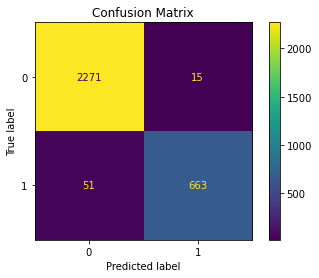

In [25]:
accuracy_result(y_test, y_predict)
auc_rf = roc_classification_report_results("Random Forest", y_test, y_predict)
show_model_confusion_matrix(y_test, y_predict, "Confusion Matrix")

##### Comparando resultado dos modelos

In [26]:
models = [("Baseline", auc_baseline),
          ("Regressão Logística", auc_logis),
          ("Tree Decision", auc_dtree),
          ("Random Forest", auc_rf)
    	 ]

In [27]:
all_results = pd.DataFrame(columns=["Model", "AUC"])
for model in models: 
    all_results = all_results.append({"Model": model[0], "AUC": model[1]}, ignore_index=True)
    all_results.sort_values(by="AUC", inplace=True, ascending=False)

In [28]:
all_results

,Model,AUC
3,Random Forest,0.961005
0,Tree Decision,0.956283
1,Regressão Logística,0.595084
2,Baseline,0.500000


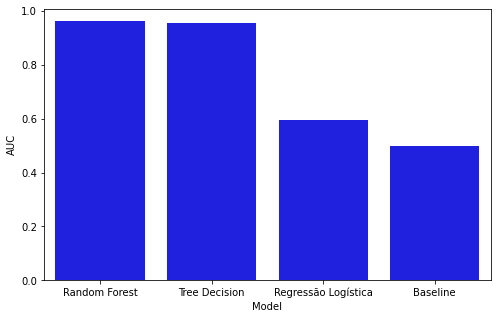

In [29]:
plt.figure(figsize=(8,5))
ax = sns.barplot(x="Model", y="AUC", data=all_results, color="b")
ax.set_xlabel("Model");

-----------

## Salvando arquivos no datalake

Os arquivos serão utilizados no script do app. Lá, pegaremos os inputs do usuário e faremos a predição com o modelo treinado, após carregá-lo a partir do datalake.

In [30]:
# Salvar modelo em disco
file_path = 'C:\Projetos Pessoais\Projeto_RHAnalytics\models\model.sav'
file_name = "model.sav"
bucket_name = "curated"
joblib.dump(rf, file_path)

# Salvar modelo no datalake
client.fput_object(
    bucket_name,
    file_name,
    file_path
)

In [31]:
# Salvar dataset final em disco
file_path = "C:\Projetos Pessoais\Projeto_RHAnalytics\datasets\dataset.csv"
file_name = "dataset.csv"
bucket_name = "curated"

df.to_csv(file_path,index=False)

# Salvar dataset final no datalake
client.fput_object(
    bucket_name,
    file_name,
    file_path
)